In [ ]:
# !git clone https://github.com/benelot/pybullet-gym.git
# !cd pybullet-gym
# !pip install -e .

In [1]:
# Imports
import gym
from gym.wrappers import Monitor
import base64
from pathlib import Path
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
import numpy as np
import pybullet
import pybulletgym
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
from enum import Enum
class Environment(Enum): # See https://github.com/benelot/pybullet-gym
    ANT = "AntMuJoCoEnv-v0"
    CHEETAH = "HalfCheetahMuJoCoEnv-v0"
    HOPPER = "HopperMuJoCoEnv-v0"
    #SWIMMER = "Swimmer-v2" # Not yet available in pybullet
    WALKER = "Walker2DMuJoCoEnv-v0"
    HUMAN = "HumanoidMuJoCoEnv-v0"

class Direction(Enum):
    POSITIVE = 1
    NEGATIVE = -1
    BEST = 0

In [3]:
class Policy():
    def __init__(self, env: gym.Env) -> None:
        self.theta = np.zeros((env.action_space.shape[0], env.observation_space.shape[0]))
    
    def evaluate(self, state, direction: int, std_exp_noise: float, delta: float):
        return (self.theta + direction * std_exp_noise * delta).dot(state.reshape(-1,1))
    
    def sample_deltas(self, n_directions):
        return np.array([np.random.randn(*self.theta.shape) for _ in range(n_directions)])
    
    def update(self, step_size, pos_rewards, neg_rewards, n_directions, deltas):
        self.theta += step_size / n_directions * np.sum((pos_rewards - neg_rewards).reshape(-1,1,1) * deltas, axis=0)

In [4]:
class BRS():
    """Basic Random Search"""
    def __init__(self, step_size: float, N: int, std_exp_noise: float) -> None:
        self.step_size = step_size
        self.N = N
        self.std_exp_noise = std_exp_noise
    
    
    def run_episode(self, env:gym.Env, policy: Policy, direction, delta):
        state = env.reset()
        done = False
        total_reward = 0
        while not done:
            action = policy.evaluate(state, direction, self.std_exp_noise, delta)
            state, reward, done, _  = env.step(action)
            reward = max(min(reward, 1), -1)
            total_reward += reward
        
        return total_reward


    def execute(self, env: gym.Env, n_steps, policy = None):
        if policy is None:
            policy = Policy(env)
        
        rewards = []
        for _ in tqdm(range(n_steps)):
            deltas = policy.sample_deltas(self.N)
            positive_rewards = np.array([self.run_episode(env, policy, Direction.POSITIVE.value, delta) for delta in deltas])
            negative_rewards = np.array([self.run_episode(env, policy, Direction.NEGATIVE.value, delta) for delta in deltas])

            policy.update(self.step_size, positive_rewards, negative_rewards, self.N, deltas)
            rewards.append(self.run_episode(env, policy, Direction.BEST.value, 0))
        
        return policy, rewards


In [5]:
from dataclasses import dataclass

@dataclass
class HyperParameters:
    nb_steps: int = 50000
    learning_rate: float = 0.01
    nb_directions: int = 8
    std_exp_noise: float = 0.025
    seed: int = 8953

In [6]:

hp = HyperParameters()
brs = BRS(hp.learning_rate, hp.nb_directions, hp.std_exp_noise)
env = gym.make(Environment.HOPPER.value)
policy, rewards = brs.execute(env, hp.nb_steps)



C:\Users\Utilisateur\Envs\inf8953-project\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


WalkerBase::__init__


100%|██████████| 50000/50000 [56:45<00:00, 14.68it/s]


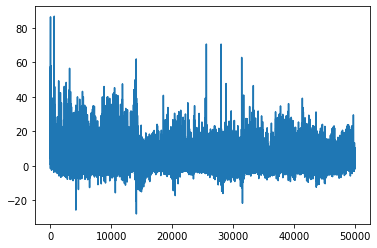

In [7]:
plt.plot(rewards)